In [6]:
# 0 - Config & imports
import os
import gc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from tqdm import tqdm

# ML imports
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# Filepaths - adjust if different
RAW_GZ = "C:/Users/HP/OneDrive/Desktop/work/accepted_2007_to_2018Q4.csv.gz"  # change if different
SAMPLED_CSV = "./data/sampled/accepted_sample_200k.csv"
PROCESSED_CSV = "./data/processed/processed_sample_200k.csv"
PREPROCESSOR_JOBLIB = "./models/preprocessor.joblib"
MODEL_PTH = "./models/torch_mlp.pth"
METRICS_JOBLIB = "./models/supervised_metrics.joblib"
DISAGREE_CSV = "./analysis/policy_disagreements_sample.csv"

# Create folders
os.makedirs(os.path.dirname(SAMPLED_CSV), exist_ok=True)
os.makedirs(os.path.dirname(PROCESSED_CSV), exist_ok=True)
os.makedirs(os.path.dirname(PREPROCESSOR_JOBLIB), exist_ok=True)
os.makedirs(os.path.dirname(MODEL_PTH), exist_ok=True)
os.makedirs(os.path.dirname(DISAGREE_CSV), exist_ok=True)

print("Config ready")


Config ready


In [7]:
# 1 - Create a ~200k random sample from the huge csv.gz using chunked reading
target_n = 200_000
chunksize = 200_000  # tune based on RAM
rng = np.random.RandomState(42)

if not os.path.exists(SAMPLED_CSV):
    print("Sampling from raw file (this can take a while)...")
    sampled_parts = []
    total_read = 0
    for chunk in pd.read_csv(RAW_GZ, low_memory=False, chunksize=chunksize):
        total_read += len(chunk)
        # sample proportionally from each chunk to reach approx target_n
        frac = min(1.0, target_n / max(total_read, 1))
        # better: reservoir-like sampling: randomly sample rows from each chunk with prob p
        # We'll do per-chunk sampling by fraction but keep final trim
        part = chunk.sample(frac=min(1.0, target_n / max(len(chunk),1)), random_state=rng) if len(chunk)>0 else chunk
        sampled_parts.append(part)
        # if we've already accumulated enough, break (but better to continue to get randomness)
        if sum(len(p) for p in sampled_parts) >= target_n*1.5:
            # stop early to save time
            break
    sampled_df = pd.concat(sampled_parts, ignore_index=True)
    if len(sampled_df) > target_n:
        sampled_df = sampled_df.sample(n=target_n, random_state=42).reset_index(drop=True)
    sampled_df.to_csv(SAMPLED_CSV, index=False)
    print(f"Saved sampled CSV with {len(sampled_df)} rows to {SAMPLED_CSV}")
else:
    print("Sample already exists:", SAMPLED_CSV)


Sampling from raw file (this can take a while)...
Saved sampled CSV with 200000 rows to ./data/sampled/accepted_sample_200k.csv


sample shape: (200000, 151)

loan_status counts:
loan_status
Fully Paid            142382
Charged Off            35829
Current                20699
Late (31-120 days)       677
In Grace Period          295
Late (16-30 days)        118
Name: count, dtype: int64

Top columns and null fraction:
member_id                                     1.000000
sec_app_num_rev_accts                         1.000000
sec_app_open_act_il                           1.000000
sec_app_inq_last_6mths                        1.000000
sec_app_open_acc                              1.000000
sec_app_mort_acc                              1.000000
sec_app_mths_since_last_major_derog           1.000000
sec_app_collections_12_mths_ex_med            1.000000
sec_app_chargeoff_within_12_mths              1.000000
sec_app_fico_range_low                        1.000000
sec_app_earliest_cr_line                      1.000000
sec_app_revol_util                            1.000000
sec_app_fico_range_high                       1

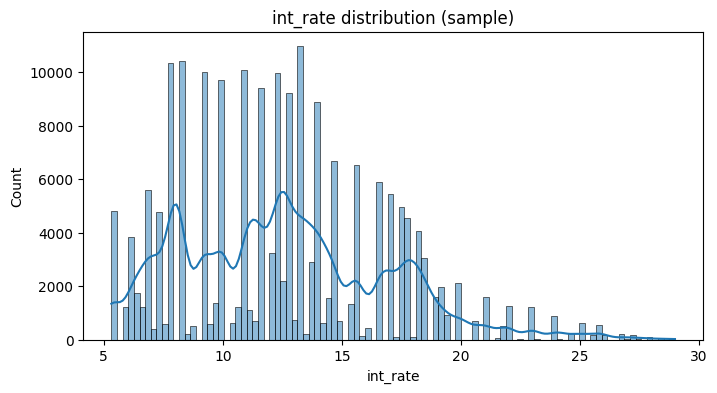

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,56984512,NaN,28000.0,28000.0,28000.0,36 months,7.89,876.00,A,A5,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,68029869,NaN,16450.0,16450.0,16450.0,36 months,9.17,524.41,B,B2,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,66014368,NaN,30000.0,30000.0,30000.0,60 months,19.99,794.65,E,E4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,59311930,NaN,20000.0,20000.0,20000.0,36 months,7.26,619.93,A,A4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,39622313,NaN,15000.0,15000.0,15000.0,36 months,7.49,466.53,A,A4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# 2 - Quick EDA on sampled data
df = pd.read_csv(SAMPLED_CSV, low_memory=False)
print("sample shape:", df.shape)
print("\nloan_status counts:")
print(df['loan_status'].value_counts(dropna=False).head(20))

# Show top 10 columns and missingness
print("\nTop columns and null fraction:")
print(df.isnull().mean().sort_values(ascending=False).head(30))

# Plot interest rate distribution (if present)
if 'int_rate' in df.columns:
    plt.figure(figsize=(8,4))
    tmp = df['int_rate'].astype(str).str.rstrip('%').replace('nan', np.nan)
    tmp = pd.to_numeric(tmp, errors='coerce')
    sns.histplot(tmp.dropna(), kde=True, bins=100)
    plt.title('int_rate distribution (sample)')
    plt.show()
else:
    print("int_rate not in columns")

# Show a few rows
df.head()


In [10]:
# 3 - Preprocessing: map target, select features, build pipeline
def map_target(status):
    # conservative mapping: treat 'Charged Off' and 'Default' as default(1); Fully Paid/Current -> 0
    bad = {"Charged Off", "Default"}
    good = {"Fully Paid", "Current", "Does not meet the credit policy. Status:Fully Paid", "In Grace Period"}
    if pd.isna(status):
        return np.nan
    if status in bad:
        return 1
    if status in good:
        return 0
    # Other statuses default to 0 (you can adjust)
    if "Charged Off" in str(status):
        return 1
    return 0

# Add target
df['target'] = df['loan_status'].apply(map_target)
df = df[~df['target'].isna()].reset_index(drop=True)
print("After filtering rows w/ target:", df.shape)

# Basic feature shortlist (edit if unavailable)
numeric_features = []
for c in ['loan_amnt','int_rate','annual_inc','dti','delinq_2yrs','revol_bal','revol_util','total_acc','open_acc']:
    if c in df.columns:
        numeric_features.append(c)
categorical_features = []
for c in ['term','grade','sub_grade','emp_length','home_ownership','verification_status','purpose','addr_state']:
    if c in df.columns:
        categorical_features.append(c)

print("Numeric features:", numeric_features)
print("Categorical features:", categorical_features)

# Clean percent columns to numeric (keep originals for RL reward)
if 'int_rate' in df.columns:
    df['int_rate_orig'] = df['int_rate']  # preserve original
    df['int_rate'] = pd.to_numeric(df['int_rate'].astype(str).str.rstrip('%'), errors='coerce')  # as float
if 'revol_util' in df.columns:
    df['revol_util'] = pd.to_numeric(df['revol_util'].astype(str).str.rstrip('%'), errors='coerce')

# Keep original loan_amnt as well
if 'loan_amnt' in df.columns:
    df['loan_amnt_orig'] = pd.to_numeric(df['loan_amnt'], errors='coerce')

# Build preprocessing pipeline
num_feats_existing = [c for c in numeric_features if c in df.columns]
cat_feats_existing = [c for c in categorical_features if c in df.columns]

num_transformer = Pipeline([('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())])
cat_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])


preprocessor = ColumnTransformer([
    ('num', num_transformer, num_feats_existing),
    ('cat', cat_transformer, cat_feats_existing)
], remainder='drop')

X = df[num_feats_existing + cat_feats_existing]
print("Fitting preprocessor on X shape:", X.shape)
preprocessor.fit(X)

# Transform and save processed DataFrame (keep loan_amnt_orig and int_rate_orig for reward calc)
X_trans = preprocessor.transform(X)  # numpy array
# generate feature names
ohe_names = []
if len(cat_feats_existing)>0:
    ohe = preprocessor.named_transformers_['cat'].named_steps['onehot']
    ohe_names = ohe.get_feature_names_out(cat_feats_existing).tolist()
feature_names = num_feats_existing + ohe_names

df_processed = pd.DataFrame(X_trans, columns=feature_names)
# attach preserved originals used for reward
if 'loan_amnt_orig' in df.columns:
    df_processed['loan_amnt_orig'] = df['loan_amnt_orig'].values
if 'int_rate_orig' in df.columns:
    # sometimes int_rate_orig contains '%' string, convert numeric percent if possible
    tmp = pd.to_numeric(df['int_rate_orig'].astype(str).str.rstrip('%'), errors='coerce')
    df_processed['int_rate_orig'] = tmp.values
df_processed['target'] = df['target'].values

# Save preprocessor & processed CSV
joblib.dump({'preprocessor': preprocessor, 'numeric_features': num_feats_existing, 'categorical_features': cat_feats_existing, 'feature_names': feature_names}, PREPROCESSOR_JOBLIB)
df_processed.to_csv(PROCESSED_CSV, index=False)
print("Saved preprocessor and processed CSV:", PREPROCESSOR_JOBLIB, PROCESSED_CSV)


After filtering rows w/ target: (200000, 154)
Numeric features: ['loan_amnt', 'int_rate', 'annual_inc', 'dti', 'delinq_2yrs', 'revol_bal', 'revol_util', 'total_acc', 'open_acc']
Categorical features: ['term', 'grade', 'sub_grade', 'emp_length', 'home_ownership', 'verification_status', 'purpose', 'addr_state']
Fitting preprocessor on X shape: (200000, 17)
Saved preprocessor and processed CSV: ./models/preprocessor.joblib ./data/processed/processed_sample_200k.csv
